# Connections Visualization

In [1]:
#@title Pairwise distances
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

def make_hello(N=1000, rseed=42):
  # Make a plot with "HELLO" text; save as PNG
  fig, ax = plt.subplots(figsize=(4, 1))
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  ax.axis('off')
  ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
  fig.savefig('hello.png')
  plt.close(fig)
  # Open this PNG and draw random points from it
  from matplotlib.image import imread
  data = imread('hello.png')[::-1, :, 0].T
  rng = np.random.RandomState(rseed)
  X = rng.rand(4 * N, 2)
  i, j = (X * data.shape).astype(int).T
  mask = (data[i, j] < 1)
  X = X[mask]
  X[:, 0] *= (data.shape[0] / data.shape[1])
  X = X[:N]
  return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))

import numpy as np

# arrange "hello" in non-linear, S-shaped way
def make_hello_s_curve(X):
  t = (X[:, 0] - 2) * 0.75 * np.pi
  x = np.sin(t)
  y = X[:, 1]
  z = np.sign(t) * (np.cos(t) - 1)
  return np.vstack((x, y, z)).T
XS = make_hello_s_curve(X)

from plotly.subplots import make_subplots
import plotly.graph_objects as go
colors = ['rgb(' + np.array2string(c[:-1], formatter={'float_kind':lambda x:  "%.0f" % (x * 255)}, separator=',')[1:-1] + ')' for c in colorize['cmap'](0.255*colorize['c'])]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])

fig.add_trace(go.Scatter3d(x=XS[:, 0], y=XS[:, 1], z=XS[:, 2],
                           mode='markers', name='datapoints (LEFT)',
                           marker=dict(
                              size=5,
                              opacity=0.8,
                              color=colors
                            )
                           ), row=1, col=1)
fig.add_trace(go.Scatter3d(x=XS[:, 0], y=XS[:, 1], z=XS[:, 2],
                           mode='markers', name='datapoints (RIGHT)',
                           marker=dict(
                              size=5,
                              opacity=0.8,
                              color=colors
                            )
                           ), row=1, col=2)

# construct lines for LLE
from sklearn.neighbors import NearestNeighbors

N_neighbours = 100

rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
nbrs = NearestNeighbors(n_neighbors=N_neighbours, radius=100.0).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = []
for i in range(100):
  for j in nbrs[i]:
    lines_LLE = lines_LLE + [XS[ind[i]], XS[j], np.array([None, None, None])]
lines_LLE = np.array(lines_LLE)

fig.add_trace(go.Scatter3d(
    x=lines_LLE[:, 0],
    y=lines_LLE[:, 1],
    z=lines_LLE[:, 2],
    mode='lines', opacity=0.2,
    line={'color': 'rgb(0,0,0)', 'width': 1},
    name='LLE connections'
), row=1, col=1)

# construct lines for MDS
lines_MDS = []
for i in ind[:100]:
  for j in ind[100:200]:
    lines_MDS = lines_MDS + [XS[i], XS[j], np.array([None, None, None])]
lines_MDS = np.array(lines_MDS)

fig.add_trace(go.Scatter3d(
    x=lines_MDS[:, 0],
    y=lines_MDS[:, 1],
    z=lines_MDS[:, 2],
    mode='lines', opacity=0.1,
    line={'color': 'rgb(0,0,0)', 'width': 1},
    name='MDS connections'
), row=1, col=2)

fig.show()


C:\Temp\ipykernel_2504\567815745.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))


#Sklearn manifold learning methods

Используйте следующий пример, чтобы получить представление о том, как работает многообразное обучение. 
* Попробуйте разные параметры для MDS и Isomap. Обратите внимание, что `n_neighbours` **значительно** меняет результат. Попробуйте разные значения, чтобы увидеть эффект 
* Реализуйте свою собственную поверхность, изменив функцию custom(X)`. В качестве примера приведена рулетка.

In [2]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

def linear_embedding(datapoints):
  model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified', eigen_solver='dense')
  return model.fit_transform(datapoints)

def multidim_scaling(datapoints):
  model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
  D = pairwise_distances(X)
  return model.fit_transform(D)

from sklearn.manifold import Isomap
def isomap(datapoints):
  model = Isomap(n_components = 2, n_neighbors=200)
  return model.fit_transform(datapoints)


"""def custom(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
  b_y = b_x - 0.2
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  roulette = np.array([[(2 + p[0]) * np.cos(2 * p[0]), (2 + p[0]) * np.sin(2 * p[0]), 2.0 * p[1]] for p in params])
  return roulette"""

def custom(X):
  b_x = np.min(X[:,0])
  k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi)
  b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
  k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
  params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
  helicoid = np.array([[p[1] * np.cos(p[0]), p[1] * np.sin(p[0]), 2.0 * p[0]] for p in params])
  return helicoid

In [ ]:
#@title Explore manifold learning (ipywidgets version) - ИСПРАВЛЕННЫЙ ПОРЯДОК
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib as mpl
import base64
import io
from IPython.display import display, clear_output
import ipywidgets as widgets
from scipy.spatial import Delaunay
import datetime

from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap
from sklearn.metrics import pairwise_distances

# ========== ИНИЦИАЛИЗАЦИЯ ДАННЫХ ==========
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

def make_hello(N=1000, rseed=42):
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'I❤FMI', va='center', ha='center', weight='bold', size=85)
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[::-1,:,:]
    plt.close(fig)
    data = np.zeros(img.shape[:2])
    data[np.sum(img, axis=2) < 250*3] = 1
    data = data.T

    col_text = MplColorHelper('rainbow', 0, data.shape[0])
    col_back = MplColorHelper('binary', 0, data.shape[0])

    X = np.random.random_sample((N, 2)) * data.shape
    colors = col_text.get_rgb(X[:, 0])
    mask = (data[X[:,0].astype(int), X[:,1].astype(int)] < 1)
    colors[mask] = col_back.get_rgb(X[mask, 0])
    return X, colors

# Глобальные данные
X, cols = make_hello(3000)
colors = ['rgb(' +
         np.array2string(c[:-1],
                         formatter={'float_kind':lambda x:  "%.0f" % (x * 255)},
                         separator=',')[1:-1] +
         ')' for c in cols]

# ========== ФУНКЦИИ МАНИФОЛДОВ ==========
def linear_embedding(datapoints, neighbors):
    model = LocallyLinearEmbedding(n_neighbors=neighbors, n_components=2, method='modified', eigen_solver='dense')
    return model.fit_transform(datapoints)

def multidim_scaling(datapoints, neighbors):
    model = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress='auto')
    D = pairwise_distances(datapoints)
    return model.fit_transform(D)

def isomap(datapoints, neighbors):
    model = Isomap(n_components=2, n_neighbors=neighbors)
    return model.fit_transform(datapoints)

def unwind_manifold(datapoints, method, neighbors):
    methods = {'lle': linear_embedding, 'mds': multidim_scaling, 'isomap': isomap}
    return methods[method](datapoints, neighbors)

# ========== ФУНКЦИИ ПРЕОБРАЗОВАНИЯ В 3D ==========
def s_curve(X):
    t = (X[:, 0] - np.min(X[:, 0])) / (np.max(X[:, 0]) - np.min(X[:, 0]))
    t = (t * 2.0 - 1.0) * np.pi * 1.5
    x = np.sin(t)
    y = X[:, 1] / np.max(X[:, 0]) * 2 * np.pi
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

def mobius(X):
    b_x = np.min(X[:,0])
    k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.1)
    b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
    k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
    params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
    return np.array([[(1.0 + p[1]/2.0 * np.cos(p[0]/2)) * np.cos(p[0]), 
                     (1.0 + p[1]/2.0 * np.cos(p[0]/2)) * np.sin(p[0]), 
                     p[1]/2.0 * np.sin(p[0]/2)] for p in params])

def cylinder(X):
    b_x = np.min(X[:,0])
    k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.1)
    b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
    k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
    params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
    return np.array([[2.0 * np.cos(p[0]), 2.0 * np.sin(p[0]), p[1]] for p in params])

def helicoid(X):
    b_x = np.min(X[:,0])
    k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi)
    b_y = 0.5 * (np.max(X[:,1]) + np.min(X[:,1]))
    k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
    params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
    return np.array([[p[1] * np.cos(p[0]), p[1] * np.sin(p[0]), 2.0 * p[0]] for p in params])

def cone(X):
    b_x = np.min(X[:,0])
    k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
    b_y = b_x - 0.2
    k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
    params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
    return np.array([[p[1] * np.cos(p[0]), p[1] * np.sin(p[0]), 2.0 * p[1]] for p in params])

def plane(X):
    return np.array([[x[0], x[1], x[0] + x[1]] for x in X])

def roll(X):
    b_x = np.min(X[:,0])
    k_x = (np.max(X[:,0]) - np.min(X[:,0])) / (2 * np.pi - 0.2)
    b_y = b_x - 0.2
    k_y = 0.5 * (np.max(X[:,1]) - np.min(X[:,1]))
    params = [[(x[0] - b_x)/k_x, (x[1] - b_y)/k_y] for x in X]
    return np.array([[(2 + p[0]) * np.cos(2 * p[0]), 
                     (2 + p[0]) * np.sin(2 * p[0]), 
                     2.0 * p[1]] for p in params])

MANIFOLD_FUNCTIONS = {
    'plane': plane,
    'mobius': mobius,
    's_curve': s_curve,
    'cylinder': cylinder,
    'helicoid': helicoid,
    'cone': cone,
    'roll': roll,
    'custom': custom
}

def transform_to_3d(x, manifold):
    return MANIFOLD_FUNCTIONS[manifold](x)

def plot_unwinded(x):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    ax.tick_params(axis="y", direction="in", pad=-40)
    ax.tick_params(axis="x", direction="in", pad=-15)
    ax.scatter(x[:, 0], x[:, 1], c=cols)
    plt.close(fig)
    return fig

def figure_to_base64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8').replace('\n', '')
    buf.close()
    return image_base64

# ========== ОСНОВНОЙ КЛАСС ПРИЛОЖЕНИЯ ==========
class ManifoldExplorerApp:
    def __init__(self):
        # Создаем выходы для отображения
        self.header_output = widgets.Output()
        self.output_plot = widgets.Output(layout={'width': '600px', 'height': '600px', 'border': '1px solid #ddd'})
        self.output_image = widgets.Output(layout={'width': '600px', 'height': '600px', 'border': '1px solid #ddd'})
        self.info_output = widgets.Output()
        self.status_output = widgets.Output()
        
        # Инициализируем виджеты
        self.init_widgets()
        self.create_layout()
        
        # Показываем заголовок
        self.show_header()
    
    def init_widgets(self):
        """Инициализация всех виджетов"""
        # Виджеты управления
        self.manifold_select = widgets.Dropdown(
            options=[
                ('Plane in 3D', 'plane'),
                ('Mobius strip', 'mobius'),
                ('S-shaped sheet', 's_curve'),
                ('Cylinder', 'cylinder'),
                ('Helicoid', 'helicoid'),
                ('Cone', 'cone'),
                ('Swiss Roll', 'roll'),
                ('Custom', 'custom')
            ],
            value='plane',
            description='📐 Manifold:',
            style={'description_width': '120px'}
        )
        
        self.method_select = widgets.Dropdown(
            options=[
                ('Locally Linear Embedding (LLE)', 'lle'),
                ('Multidimensional Scaling (MDS)', 'mds'),
                ('Isomap', 'isomap')
            ],
            value='lle',
            description='🔧 Method:',
            style={'description_width': '120px'}
        )
        
        self.neighbors_slider = widgets.IntSlider(
            value=100,
            min=5,
            max=500,
            step=5,
            description='👥 Neighbors:',
            style={'description_width': '120px'}
        )
        
        self.unfold_button = widgets.Button(
            description='🚀 Unfold',
            button_style='success',
            icon='rocket',
            layout={'width': '200px', 'margin': '10px 0'}
        )
        
        self.progress = widgets.FloatProgress(
            value=0,
            min=0,
            max=1,
            description='⏳ Progress:',
            bar_style='info',
            style={'description_width': '120px'}
        )
        
        # Дополнительные виджеты
        self.auto_update = widgets.Checkbox(
            value=False,
            description='Auto update',
            style={'description_width': 'initial'}
        )
        
        self.show_grid = widgets.Checkbox(
            value=True,
            description='Show 3D grid',
            style={'description_width': 'initial'}
        )
        
        self.point_size = widgets.FloatSlider(
            value=20,
            min=1,
            max=100,
            description='Point size:',
            style={'description_width': '100px'}
        )
        
        # Привязка событий
        self.unfold_button.on_click(self.on_unfold_click)
        self.manifold_select.observe(self.on_parameter_change, names='value')
        self.method_select.observe(self.on_parameter_change, names='value')
        self.neighbors_slider.observe(self.on_parameter_change, names='value')
        self.auto_update.observe(self.on_auto_update_change, names='value')
    
    def create_layout(self):
        """Создание layout интерфейса"""
        # Панель управления
        controls_box = widgets.VBox([
            widgets.HTML("<h3>⚙️ Controls</h3>"),
            self.manifold_select,
            self.method_select,
            self.neighbors_slider,
            widgets.HBox([
                self.auto_update,
                self.show_grid
            ]),
            self.point_size,
            self.unfold_button,
            self.progress,
            widgets.HTML("<h3>📊 Status</h3>"),
            self.status_output
        ], layout={'width': '350px', 'margin': '0 20px', 'padding': '10px', 'border': '1px solid #eee', 'border_radius': '5px'})
        
        # Панель визуализации
        viz_header = widgets.HTML("<h3>📈 Visualizations</h3>")
        visualization_box = widgets.VBox([
            viz_header,
            widgets.HBox([
                widgets.VBox([
                    widgets.HTML("<center><b>3D Manifold</b></center>"),
                    self.output_plot
                ]),
                widgets.VBox([
                    widgets.HTML("<center><b>2D Unfolding</b></center>"),
                    self.output_image
                ])
            ])
        ])
        
        # Панель информации
        info_box = widgets.VBox([
            widgets.HTML("<h3>📝 Information</h3>"),
            self.info_output
        ], layout={'width': '350px', 'margin': '0 20px', 'padding': '10px', 'border': '1px solid #eee'})
        
        # Главный интерфейс
        self.main_layout = widgets.VBox([
            self.header_output,
            widgets.HBox([
                controls_box,
                visualization_box,
                info_box
            ])
        ])
    
    def show_header(self):
        """Показать заголовок приложения"""
        with self.header_output:
            clear_output()
            print("=" * 70)
            print("🚀 MANIFOLD LEARNING EXPLORER")
            print("=" * 70)
            print("📅", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
            print("📊 Data points:", X.shape[0])
            print("🎨 Colors:", len(colors))
            print("=" * 70)
            print()
    
    def display(self):
        """Отобразить приложение"""
        display(self.main_layout)
        
        # Показать начальное состояние
        with self.status_output:
            clear_output()
            print("✅ Application loaded successfully!")
            print("⏳ Ready to compute...")
            print()
            print("📋 Current parameters:")
            print(f"   • Manifold: {self.manifold_select.label}")
            print(f"   • Method: {self.method_select.label}")
            print(f"   • Neighbors: {self.neighbors_slider.value}")
    
    def on_parameter_change(self, change):
        """Обработчик изменения параметров"""
        with self.status_output:
            clear_output()
            print("📝 Parameters updated:")
            print(f"   • Manifold: {self.manifold_select.label}")
            print(f"   • Method: {self.method_select.label}")
            print(f"   • Neighbors: {self.neighbors_slider.value}")
            
            if self.auto_update.value:
                print("🔄 Auto-update enabled - computing...")
                # Запускаем вычисление через небольшой таймаут чтобы избежать множественных вызовов
                import threading
                def delayed_compute():
                    import time
                    time.sleep(0.5)
                    self.unfold_button.click()
                threading.Thread(target=delayed_compute).start()
    
    def on_auto_update_change(self, change):
        """Обработчик изменения auto-update"""
        with self.status_output:
            clear_output()
            if self.auto_update.value:
                print("✅ Auto-update ENABLED")
                print("🔄 Changes will trigger automatic computation")
            else:
                print("⏸️ Auto-update DISABLED")
                print("📌 Click 'Unfold' button to compute")
    
    def on_unfold_click(self, button):
        """Обработчик нажатия кнопки Unfold"""
        with self.status_output:
            clear_output()
            print("⚡ Computing...")
        
        # Обновляем прогресс
        self.progress.value = 0.2
        
        try:
            # Получаем параметры
            manifold = self.manifold_select.value
            method = self.method_select.value
            neighbors = self.neighbors_slider.value
            
            with self.info_output:
                clear_output()
                print(f"🔍 Computing manifold: {self.manifold_select.label}")
                print(f"🔧 Using method: {self.method_select.label}")
                print(f"👥 Neighbors: {neighbors}")
                print("-" * 40)
            
            self.progress.value = 0.4
            
            # 1. Преобразуем в 3D
            with self.status_output:
                clear_output()
                print("📐 Transforming to 3D...")
            
            man_3d = transform_to_3d(X, manifold)
            
            self.progress.value = 0.6
            
            # 2. Разворачиваем многообразие
            with self.status_output:
                clear_output()
                print("🔄 Unfolding manifold...")
            
            unwound = unwind_manifold(man_3d, method, neighbors)
            
            self.progress.value = 0.8
            
            # 3. Создаем визуализации
            with self.status_output:
                clear_output()
                print("🎨 Creating visualizations...")
            
            fig_unwound = plot_unwinded(unwound)
            image_base64 = figure_to_base64(fig_unwound)
            
            # 4. Генерируем сетку для 3D отображения
            x_ = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), num=50)
            y_ = np.linspace(np.min(X[:, 1]), np.max(X[:, 1]), num=50)
            xx, yy = np.meshgrid(x_, y_)
            x_vec = np.transpose(np.vstack([xx.ravel(), yy.ravel()]))
            Y = transform_to_3d(x_vec, manifold)
            
            # Триангуляция
            tri = Delaunay(x_vec)
            simplices = tri.simplices.tolist()
            
            self.progress.value = 0.9
            
            # 5. Отображаем результаты
            with self.status_output:
                clear_output()
                print("📊 Displaying results...")
            
            self.display_results(image_base64, man_3d, Y, simplices)
            
            self.progress.value = 1.0
            
            with self.status_output:
                clear_output()
                print("✅ Computation COMPLETED!")
                print(f"📈 Manifold: {self.manifold_select.label}")
                print(f"⚡ Method: {self.method_select.label}")
                print(f"👥 Neighbors: {neighbors}")
                print(f"📍 Points: {len(man_3d)}")
                print(f"📊 Grid: {int(np.sqrt(len(Y)))}x{int(np.sqrt(len(Y)))}")
            
            with self.info_output:
                print()
                print("✅ Results ready!")
                print(f"📏 3D dimensions: {man_3d.shape[1]}")
                print(f"🎯 Unfolded dimensions: {unwound.shape[1]}")
                print(f"📐 Grid triangles: {len(simplices)}")
                
        except Exception as e:
            with self.status_output:
                clear_output()
                print(f"❌ ERROR: {str(e)}")
                print("💡 Check parameters and try again")
            
            with self.info_output:
                print(f"❌ Error occurred: {str(e)}")
            
            self.progress.value = 0
        
        finally:
            # Сброс прогресса через 2 секунды
            import threading
            def reset_progress():
                import time
                time.sleep(2)
                self.progress.value = 0
            threading.Thread(target=reset_progress).start()
    
    def display_results(self, image_base64, man_3d, Y_grid, simplices):
        """Отображение результатов"""
        # Очищаем выходы
        self.output_plot.clear_output()
        self.output_image.clear_output()
        
        # Отображаем 2D развертку
        with self.output_image:
            display(widgets.HTML(
                f'<div style="text-align: center;">'
                f'<img src="data:image/png;base64,{image_base64}" '
                f'width="580" height="580" style="border: 1px solid #ccc;">'
                f'<p><em>2D Unfolded Representation</em></p>'
                f'</div>'
            ))
        
        # Отображаем 3D график
        with self.output_plot:
            fig = plt.figure(figsize=(6, 6))
            ax = fig.add_subplot(111, projection='3d')
            
            # Отображаем сетку если включено
            if self.show_grid.value:
                n = int(np.sqrt(len(Y_grid)))
                if n * n == len(Y_grid):
                    X_grid = Y_grid[:, 0].reshape(n, n)
                    Y_vals = Y_grid[:, 1].reshape(n, n)
                    Z_grid = Y_grid[:, 2].reshape(n, n)
                    ax.plot_wireframe(X_grid, Y_vals, Z_grid, 
                                     color='gray', alpha=0.3, linewidth=0.5)
            
            # Отображаем точки
            scatter = ax.scatter(man_3d[:, 0], man_3d[:, 1], man_3d[:, 2],
                               c=cols, s=self.point_size.value, alpha=0.8, 
                               depthshade=True)
            
            # Настройки графика
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f'3D: {self.manifold_select.label}')
            ax.grid(True)
            
            # Устанавливаем равные масштабы
            max_range = np.array([man_3d[:, 0].max()-man_3d[:, 0].min(),
                                 man_3d[:, 1].max()-man_3d[:, 1].min(),
                                 man_3d[:, 2].max()-man_3d[:, 2].min()]).max() / 2.0
            
            mid_x = (man_3d[:, 0].max()+man_3d[:, 0].min()) * 0.5
            mid_y = (man_3d[:, 1].max()+man_3d[:, 1].min()) * 0.5
            mid_z = (man_3d[:, 2].max()+man_3d[:, 2].min()) * 0.5
            
            ax.set_xlim(mid_x - max_range, mid_x + max_range)
            ax.set_ylim(mid_y - max_range, mid_y + max_range)
            ax.set_zlim(mid_z - max_range, mid_z + max_range)
            
            plt.tight_layout()
            plt.show()

# ========== ЗАПУСК ПРИЛОЖЕНИЯ ==========
if __name__ == "__main__":
    # Создаем приложение
    app = ManifoldExplorerApp()
    
    # Отображаем приложение
    app.display()
    
    # Дополнительная информация
    print("\n" + "="*70)
    print("🎯 HOW TO USE:")
    print("="*70)
    print("1. Select a manifold type from the dropdown")
    print("2. Choose an unfolding method")
    print("3. Adjust the number of neighbors")
    print("4. Click '🚀 Unfold' button")
    print("5. Enable 'Auto update' for real-time changes")
    print("="*70)

C:\Temp\ipykernel_2504\1913322598.py:33: UserWarning:

Glyph 10084 (\N{HEAVY BLACK HEART}) missing from font(s) Arial.




🎯 HOW TO USE:
1. Select a manifold type from the dropdown
2. Choose an unfolding method
3. Adjust the number of neighbors
4. Click '🚀 Unfold' button
5. Enable 'Auto update' for real-time changes


#MNIST  

* Запустите следующий код, чтобы загрузить набор данных MNIST и добавить шум 

In [4]:
from sklearn.datasets import load_digits
import numpy as np

digits = load_digits()
data, target = digits.data, digits.target
data = np.random.normal(data, 5)

* Выполните следующие функции, чтобы уменьшить размеры `данных` до 3. Ожидается, что результат будет иметь вид `(1797, 3)`.

In [5]:
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

def projected_mds(data):
  return MDS(n_components=3, random_state=42).fit_transform(data)

def projected_isomap(data):
  return Isomap(n_components=3, n_neighbors=20).fit_transform(data)

def projected_PCA(data):
  return PCA(n_components=3, random_state=42).fit_transform(data)

* Запустите код визуализации, чтобы увидеть результат.

In [6]:
#@title Visualization
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

cmap = {0: 'rgba(0,0,255,255)', 1: 'rgba(0,255,0,255)', 2: 'rgba(255,0,0,255)',
        3: 'rgba(0,0,128,255)', 4: 'rgba(0,128,0,255)', 5: 'rgba(128,0,255)',
        6: 'rgba(0,0,64,255)', 7: 'rgba(0,64,0,255)', 8: 'rgba(64,0,0,255)',
        9: 'rgba(0,0,0,255)'}
colors = [cmap[int(d)] for d in digits.target]

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "scene"}, {"type": "scene"}]])

iso_proj = projected_isomap(data)
fig.add_trace(go.Scatter3d(x=iso_proj[:, 0], y=iso_proj[:, 1], z=iso_proj[:, 2],
                           mode='markers',
                           marker=dict(size=4, color=colors)),
              row=1, col=1)

pca_proj = projected_PCA(data)
fig.add_trace(go.Scatter3d(x=pca_proj[:, 0], y=pca_proj[:, 1], z=pca_proj[:, 2],
                           mode='markers',
                           marker=dict(size=4, color=colors)),
              row=1, col=2)

fig.update_layout(width=1200, height=600, autosize=False,
                  title_text="3-component Isomap (left) and PCA (right) for MNIST",
                  scene={"xaxis": {"title": "component 1"},
                         "yaxis": {"title": "component 2"},
                         "zaxis": {"title": "component 3"}},
                  showlegend=False)

fig.show()

* разделить набор данных на поезд и тест 
* Создайте модели: 
   - любой классификатор (простой) 
   - PCA + любой классификатор
   - MDP + любой классификатор  
   - Изомап + любой классификатор 
* Обучите модели 
* Попробуйте сдеать классификацию

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, shuffle=False)

logreg = LogisticRegression()

mds = MDS(n_components=3, random_state=42)
isomap = Isomap(n_components=3, n_neighbors=15)
pca = PCA(n_components=3, random_state=42)

l_simple = logreg.fit(X_train, y_train).predict(X_test)
l_MDS = logreg.fit(mds.fit_transform(X_train), y_train).predict(mds.fit_transform(X_test))
l_isomap = logreg.fit(isomap.fit_transform(X_train), y_train).predict(isomap.fit_transform(X_test))
l_pca = logreg.fit(pca.fit_transform(X_train), y_train).predict(pca.fit_transform(X_test))
# Note:  shapes should coincide with the shape of y_test

def get_results():
  return y_test, ['Simple model', 'mds', 'isomap', 'pca'], [l_simple, l_MDS, l_isomap, l_pca]

* Запустите код визуализации, чтобы увидеть матрицы путаницы.

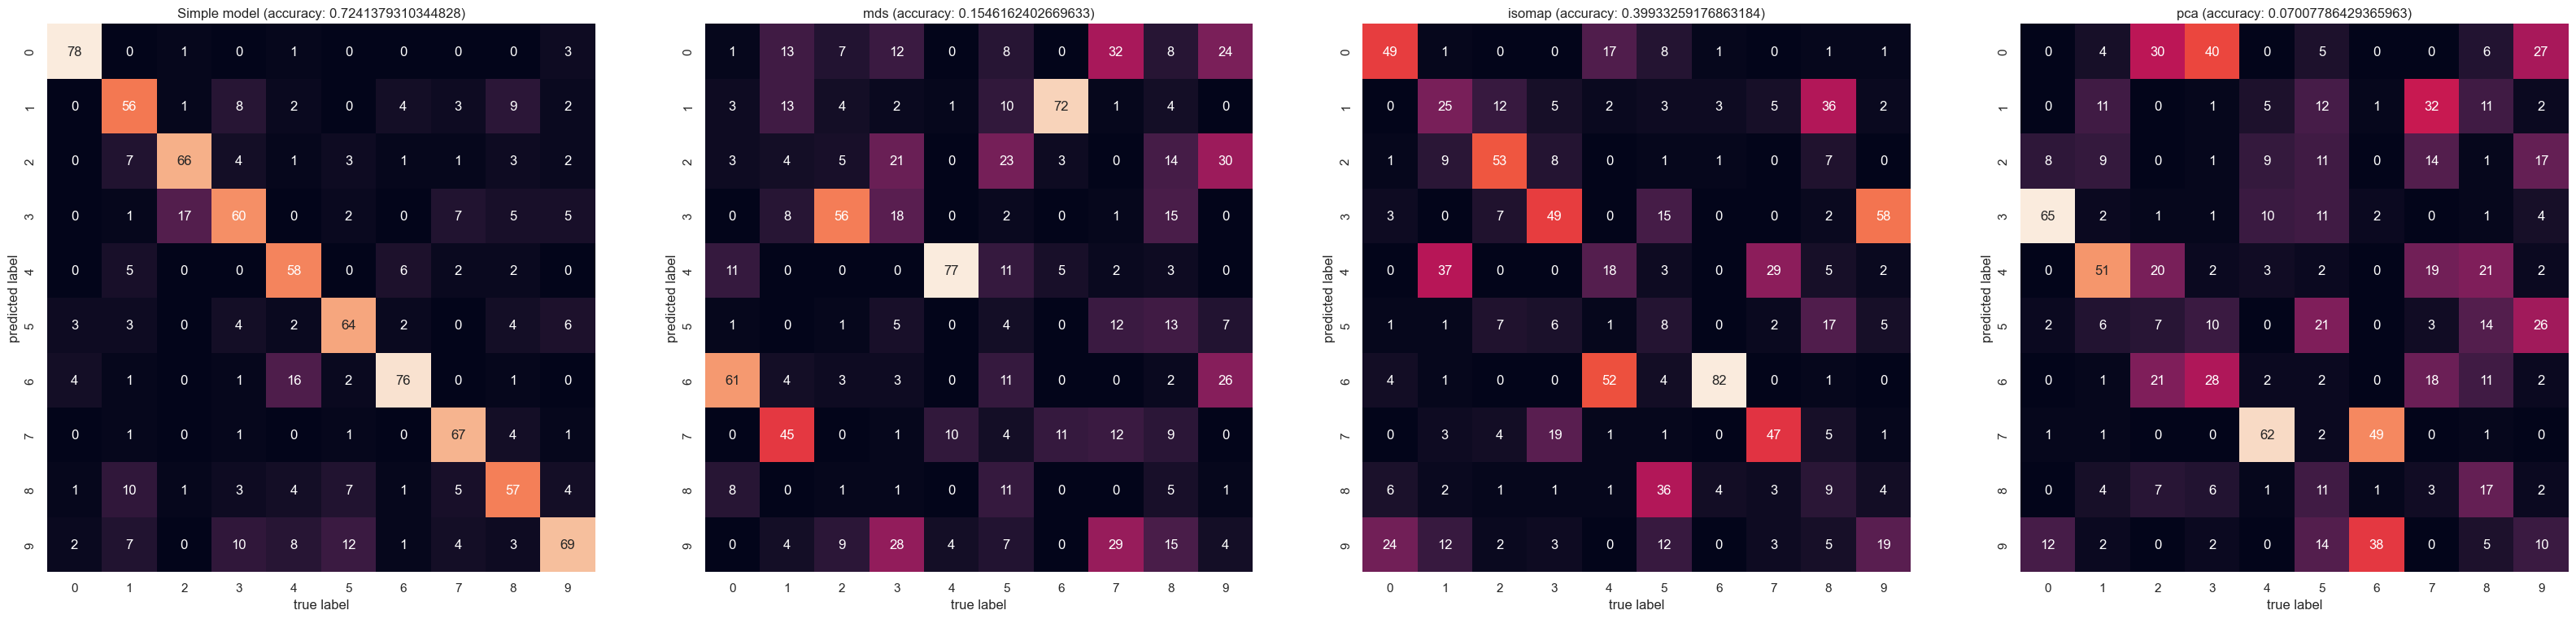

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

trg, names, labels = get_results()
num_plots = len(names)
fig = plt.figure(figsize=(10 * num_plots, 10))

for idx in range(num_plots):
  plt.subplot(1, num_plots, 1 + idx)
  mat = confusion_matrix(trg, labels[idx])
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=[i for i in range(10)],
            yticklabels=[i for i in range(10)])
  plt.ylim(10.0, 0.0)
  plt.xlabel('true label')
  plt.ylabel('predicted label')

  plt.title(names[idx] + " (accuracy: " + str(accuracy_score(trg, labels[idx])) + ")")

## Как можно заметить из метрик, классификатор до уменьшения размерности имел намного выше качество предсказаний на тесте.